In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
import sklearn.linear_model

import plotly.express as px

In [2]:
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5., 5., 5., 5.])
y = np.array([0, 1, 3, 5])

Let us consider the following probabilistic model:

\begin{align*}
y_i | p_i &\sim  \mathrm{Binomial}(n_i, p_i)\\
p_i &= \rm{sigm}(\alpha + \beta x_i)\\
\theta = 
\begin{bmatrix}
\alpha \\
\beta
\end{bmatrix} &\sim \mathcal{N}(\mu_0, \Sigma_0), \qquad 
\mu_0 = \begin{bmatrix}
0 \\
10
\end{bmatrix}, \;\;
\Sigma_0 = \begin{bmatrix}
4 & 12 \\
12 & 100
\end{bmatrix},
\end{align*}

where

\begin{align*}
\rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
\end{align*}

Let us first obtain a deterministic estimate of $\alpha$ and $\beta$ by solving the maximum likelihood problem:

$$\alpha^{\rm ml}, \beta^{\rm ml} = \arg \min_{\alpha, \beta} \mathcal{L}(\theta)$$ 

The likelihood function $\mathcal{L}(\theta)$ is:

$$\mathcal{L}(\theta) = p(y|\theta) = \prod_i {{n_i}\choose{y_i}} \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot (1- \mathrm{sigm}(\alpha + \beta x_i))^{n_i - y_i}$$

In [3]:
# sigmoid function, equivalent to logit^{-1}
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [4]:
# Likelihood of the 4 observations (neglecting a constant multiplicative factor).
# The overall likelihood is the product of all terms.

def lik_fun(alpha, beta):
    gamma = sigmoid(alpha+beta*x)
    lik = gamma**y * (1-gamma)**(n-y)
    return np.prod(lik, axis=-1)

In [5]:
# Get an initial deterministic estimate of alpha and beta (logistic regression)
#logreg = sklearn.linear_model.LogisticRegression()
#logreg.fit(x.transpose(), 1/5*y.reshape(-1)) # does not work with continuous labels

Let us visualize the likelihood function in 2D

In [6]:
dalpha = 0.01
dbeta = 0.01
ALPHA = np.arange(-4, 10, dalpha)
BETA = np.arange(-10, 40, dbeta)

AA, BB = np.meshgrid(ALPHA, BETA, indexing='xy')
LL = lik_fun(AA[..., np.newaxis], BB[..., np.newaxis])

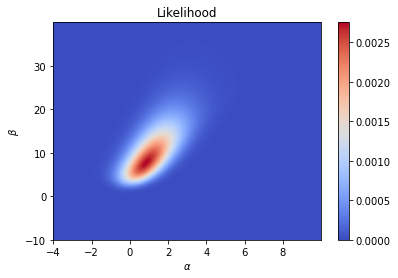

In [7]:
fig, ax = plt.subplots()
c = ax.pcolormesh(AA, BB, LL, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

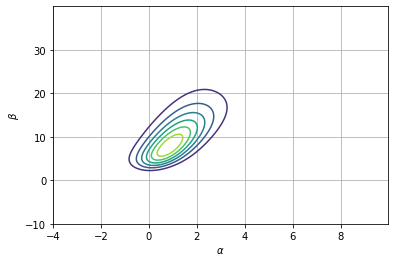

In [8]:
plt.contour(AA, BB, LL); #, levels=[5, 15,  95]); # levels=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\beta$");
plt.grid(True)

In [9]:
mu = np.array([0, 10])
cov_0 = np.array([[4, 12], [12, 100]]) 
prior_fun = stats.multivariate_normal(mean=mu, cov=cov_0)

In [10]:
dalpha = 0.01
dbeta = 0.01
ALPHA = np.arange(-4, 10, dalpha)
BETA = np.arange(-10, 40, dbeta)

AA, BB = np.meshgrid(ALPHA, BETA, indexing='xy')
LL = lik_fun(AA[..., np.newaxis], BB[..., np.newaxis])

AABB = np.stack((AA, BB), axis=-1)
PP = prior_fun.pdf(AABB) # Prior

POST_UNSC = LL * PP
normalizing_factor = np.sum(POST_UNSC)*dalpha*dbeta
POST_SC = POST_UNSC/normalizing_factor

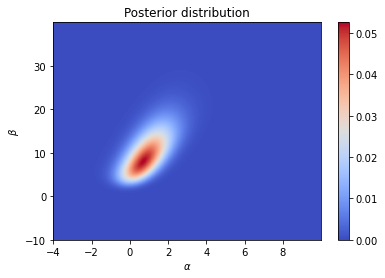

In [11]:
fig, ax = plt.subplots()
c = ax.pcolormesh(AA, BB, POST_SC, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Posterior distribution");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

In this case the, the likelihood is numerically well-posed (not too many samples, not too many multiplications). The scale 0-0.05 is not too bad!. In general, it is better to work with logarithms. Let us compute the *log-likelihood* $\ell(\theta)$:

$$\ell(\theta) = \log \mathcal{L}(\theta) = \sum_i {{n_i}\choose{y_i}} + \sum_i y_i \log \mathrm{sigm}(\alpha + \beta x_i) +  (n_i - y_i) \log (1- \mathrm{sigm}(\alpha + \beta x_i)).$$

The constant term $\sum_i {{n_i}\choose{y_i}}$ may be ignored.

In [12]:
def log_lik_fun(alpha, beta):
    gamma = sigmoid(alpha+beta*x)
    #log_lik = y*np.log(gamma) + (n-y)*np.log(1-gamma)
    # nan_to_num handles the multiplication 0*np.inf and set it to 0, as required in our case...
    log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)
    return np.sum(log_lik, axis=-1)

In [13]:
dalpha = 0.01
dbeta = 0.01
ALPHA = np.arange(-4, 10, dalpha)
BETA = np.arange(-10, 40, dbeta)

AA, BB = np.meshgrid(ALPHA, BETA, indexing='xy')
LOG_LL = log_lik_fun(AA[..., np.newaxis], BB[..., np.newaxis])

/tmp/ipykernel_36589/3957436197.py:5: RuntimeWarning: divide by zero encountered in log
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)
/tmp/ipykernel_36589/3957436197.py:5: RuntimeWarning: invalid value encountered in multiply
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)


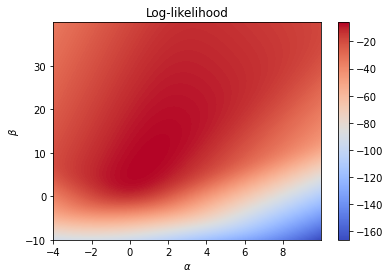

In [14]:
fig, ax = plt.subplots()
#c = ax.pcolormesh(AA, BB, np.exp(LOG_LL), cmap=cm.coolwarm, shading='auto')
c = ax.pcolormesh(AA, BB, LOG_LL, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Log-likelihood");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

In [15]:
def log_post_fun(alpha, beta):
    return log_lik_fun(alpha, beta) + prior_fun.logpdf([alpha, beta])

In [16]:
def p_ratio_fun(alpha_propose, beta_propose, alpha_previous, beta_previous):
    log_p_previous = log_post_fun(alpha_previous, beta_previous)
    log_p_propose = log_post_fun(alpha_propose, beta_propose)
    log_p_ratio = log_p_propose - log_p_previous # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    p_ratio = np.exp(log_p_ratio)
    return p_ratio

In [17]:
p_ratio_fun(alpha_propose = 1.89, alpha_previous = 0.374, beta_propose = 24.76, beta_previous = 20.04)

1.3051790385127726

In [18]:
p_ratio_fun(alpha_propose = 0.374, alpha_previous = 1.89, beta_propose = 20.04, beta_previous = 24.76)

0.7661784096222397

Let us run a Metropolis algorithm to sample from the posterior. The p_ratio function is all we need!

In [19]:
theta_0 = np.array([0, 10])
sigma = np.diag([0.5, 1.0])
theta_step = theta_0
N = 100_000
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma @ np.random.randn(2)
    #theta_prop = np.clip(theta_prop, 0, 1)
    
    p_ratio = p_ratio_fun(theta_prop[0], theta_prop[1], theta_step[0], theta_step[1])
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_step = theta_prop
thetas = np.stack(thetas)

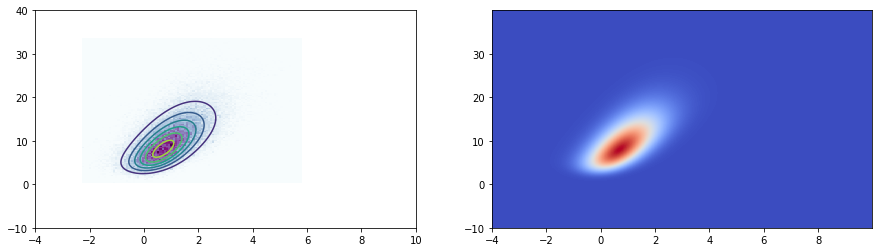

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist2d(x=thetas[:, 0], y=thetas[:, 1], bins=100, cmap=plt.cm.BuPu)
ax[0].set_xlim([-4, 10]);
ax[0].set_ylim([-10, 40]);
ax[0].contour(AA, BB, POST_SC); #, levels=[5, 15,  95]); # levels=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
c = ax[1].pcolormesh(AA, BB, POST_SC, cmap=cm.coolwarm, shading='auto')

In [21]:
np.mean(thetas[10_000:, :], axis=0)

array([ 0.98441324, 10.62740204])

In [22]:
np.cov(thetas.transpose())

array([[ 0.84565382,  2.69158747],
       [ 2.69158747, 22.00654528]])

In [23]:
np.sum(AA*POST_SC)*dalpha*dbeta, np.sum(BB*POST_SC)*dalpha*dbeta

(0.9689882694514184, 10.59065927312268)

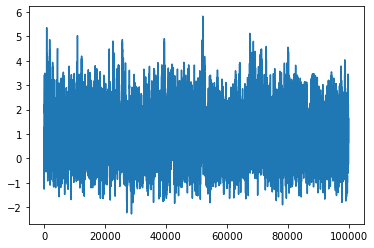

In [24]:
plt.plot(thetas[:,0])#px.scatter(thetas[:, 0])

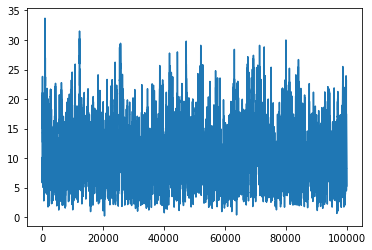

In [25]:
plt.plot(thetas[:, 1])

Let us do the sampling with pymc3

In [26]:
import pymc3 as pm

In [27]:
with pm.Model():
    theta = pm.MvNormal("theta", mu=mu, cov=cov_0, shape=(2,))
    p = pm.Deterministic("p", sigmoid(theta[0] + theta[1]*x))
    y_var = pm.Binomial("y_var", n=n, p=p, observed=y)
    trace=pm.sample(2000)

/tmp/ipykernel_36589/3897279105.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [28]:
import arviz as az

In [29]:
az.summary(trace)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.940,0.912,-0.775,2.604,0.018,0.013,2572.0,2432.0,1.0
theta[1],10.407,4.587,2.379,18.609,0.091,0.065,2563.0,3677.0,1.0
p[0],0.007,0.019,0.000,0.032,0.000,0.000,2996.0,4060.0,1.0
p[1],0.138,0.106,0.002,0.336,0.001,0.001,4729.0,4882.0,1.0
p[2],0.590,0.168,0.283,0.885,0.003,0.002,3029.0,3046.0,1.0
p[3],0.990,0.032,0.960,1.000,0.001,0.000,2342.0,3582.0,1.0


/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

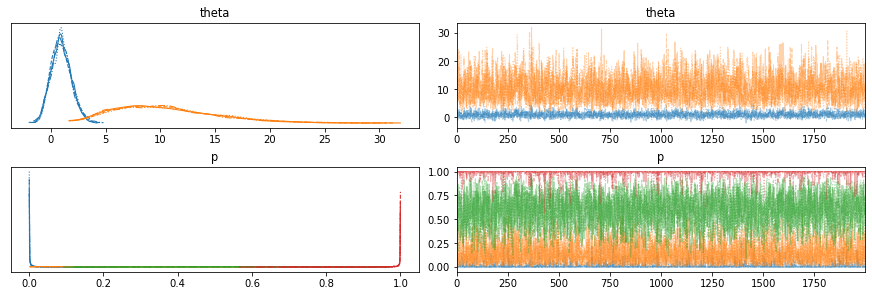

In [30]:
az.plot_trace(trace)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'p\n0'}>],
       [<AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n2'}>,
        <AxesSubplot:title={'center':'p\n3'}>]], dtype=object)

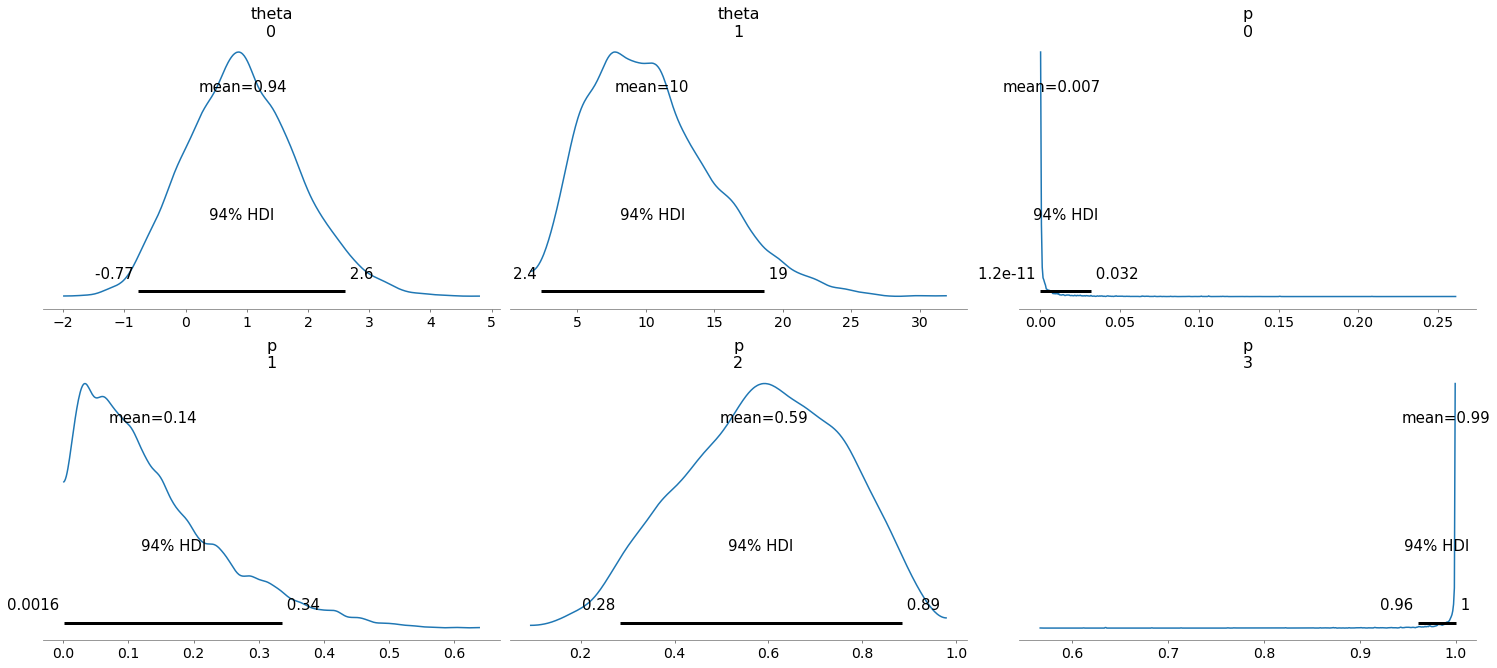

In [31]:
az.plot_posterior(trace)